## Executive Summary

This notebook complements `HMM-NoJumps-Simulation-Notebook` in modeling of daily stock excess growth rates using Hidden Markov Models (HMMs) with jumps. This hybird HMM model incorporates growth jumps demonstrating improved ability to replicate observed market dynamics.

 # Build a Hidden Markov Model of Daily Stock Excess Growth Rate
We are constructing an Observable Markov Model (OMM) of the excess growth rate of a ticker `XYZ` where we define the excess growth as:
$$
\begin{equation*}
R_{ij} \equiv \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{i,j}}{S_{i,j-1}}\right) - \bar{r}_{f}
\end{equation*}
$$
where $R_{ij}$ denotes the excess growth rate of equity $i$ at time $j$, $\Delta{t}$ denotes the time-step between $j-1\rightarrow{j}$ (units: years), $S_{i,\star}$ denotes the share price of equity $i$ at time $\star$, and $\bar{r}_{f}$ denotes the annualized risk free rate. In this work, we build a model of daily return.

## Model
Describe the day-to-day variation of the excess growth using a fully observable Markov model $\mathcal{M}$ represented by the tuple $\mathcal{M} = (\mathcal{S},\mathcal{O},\mathbf{P},\mathbf{E})$; $\mathcal{S}$ is the set of hidden states, $\mathcal{O}$ is the set of observable states, $\mathbf{T}$ is the transition matrix, i.e., $t_{ij}\in\mathbf{T}$ is the probability of moving from hidden state $i$ to hidden state $j$ in the next time step, and $\mathbf{E}$ is the emission matrix. Because we are fully observable, the emission matrix $\mathbf{E} = \mathbf{I}$, where $\mathbf{I}$ is the identity matrix.

## Objectives
- **Task 1:** Characterize the continuous distribution of returns using MLE and MCMC, then discretize this distribution to build a Hidden Markov Model (HMM).
- **Task 2:** Simulate and analyze an HMM with jumps to see if it improves upon the standard model's weaknesses.
- **Task 3:** Save the final model artifacts for future use.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [1]:
include("Include.jl");

## Setting Up Constants

In [2]:
risk_free_rate = 0.0421; # 17-Jun-2024 10-year treasury
Δt = (1/252); # time step 1 x trading in units of years
number_of_paths = 100; # number of potential futures should we look at
ticker = "SPY"; # This is the ticker we want to explore

### Load the training data

The training dataset for this analysis consists of daily open-high-low-close (OHLC) data for firms in the S&P 500, spanning from **January 3, 2014, to December 29, 2023** (2515 trading days). This data was cleaned and split into training and testing sets in a separate preprocessing step.

We begin by loading the pre-cleaned **training dataset** below.

In [3]:
train_dataset = MyPortfolioDataSet() |> x->x["train_dataset"]

Dict{String, DataFrame} with 424 entries:
  "EMR"  => 2515×8 DataFrame…
  "CTAS" => 2515×8 DataFrame…
  "HSIC" => 2515×8 DataFrame…
  "KIM"  => 2515×8 DataFrame…
  "PLD"  => 2515×8 DataFrame…
  "IEX"  => 2515×8 DataFrame…
  "BAC"  => 2515×8 DataFrame…
  "CBOE" => 2515×8 DataFrame…
  "EXR"  => 2515×8 DataFrame…
  "NCLH" => 2515×8 DataFrame…
  "CVS"  => 2515×8 DataFrame…
  "DRI"  => 2515×8 DataFrame…
  "DTE"  => 2515×8 DataFrame…
  "ZION" => 2515×8 DataFrame…
  "AVY"  => 2515×8 DataFrame…
  "EW"   => 2515×8 DataFrame…
  "EA"   => 2515×8 DataFrame…
  "NWSA" => 2515×8 DataFrame…
  "CAG"  => 2515×8 DataFrame…
  "GILD" => 2515×8 DataFrame…
  "FCX"  => 2515×8 DataFrame…
  "GPC"  => 2515×8 DataFrame…
  "UNP"  => 2515×8 DataFrame…
  "CDW"  => 2515×8 DataFrame…
  "SBUX" => 2515×8 DataFrame…
  ⋮      => ⋮

In [4]:
train_dataset["AAPL"]

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,3.93215e8,19.4749,19.745,19.3207,19.775,19.3011,2014-01-03T05:00:00,148584
2,4.13437e8,19.3213,19.1946,19.4261,19.5286,19.0571,2014-01-06T05:00:00,131664
3,3.17731e8,19.3329,19.44,19.2871,19.4986,19.2116,2014-01-07T05:00:00,107327
4,2.58747e8,19.4038,19.2432,19.4093,19.4843,19.2389,2014-01-08T05:00:00,86874
5,2.79621e8,19.2943,19.5286,19.1614,19.5307,19.1196,2014-01-09T05:00:00,93562
6,3.05283e8,19.0659,19.2796,19.0336,19.3143,18.9682,2014-01-10T05:00:00,113063
7,3.79443e8,19.1801,18.9254,19.1332,19.375,18.9243,2014-01-13T05:00:00,130227
8,3.34937e8,19.4033,19.2221,19.5139,19.5261,19.2021,2014-01-14T05:00:00,114856
9,3.9389e8,19.9105,19.7686,19.9057,20.0071,19.7021,2014-01-15T05:00:00,136942


In [5]:
maximum_number_trading_days = nrow(train_dataset["AAPL"])

2515

Lastly, let's get a sorted list of firms that we have in cleaned up `dataset` and save it in the `list_of_all_tickers::Array{String,1}` array

In [6]:
list_of_all_tickers = keys(train_dataset) |> collect |> x->sort(x)

424-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 "ADM"
 "ADP"
 "ADSK"
 "AEE"
 ⋮
 "WST"
 "WU"
 "WY"
 "WYNN"
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBRA"
 "ZION"
 "ZTS"

We compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `list_of_all_tickers` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix).
* The result is stored in the `all_firms_return_matrix::Array{Float64,2}` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [7]:
all_firms_excess_return_matrix = log_growth_matrix(train_dataset, list_of_all_tickers,
    Δt = Δt, risk_free_rate = risk_free_rate)

2514×424 Matrix{Float64}:
 -0.919654   6.23895   -2.91307    …  -0.797491   0.203794  -1.04737
  2.77416    1.02939    1.35029        2.09622   -0.84489    0.944368
  3.27095    0.813497  -0.036732       0.067777   1.1489    -2.62354
  0.604325  17.2178     1.65005        0.232616   3.1172    -0.410328
  1.77399    2.53751    3.27714        0.579577  -2.2108     4.36099
  0.57173   -4.00594   -0.83488    …  -0.904839  -1.95187   -3.15834
  2.81861   -0.525851   4.80363        1.7236    -1.81895   -1.1317
  2.00461    0.971404   1.86599        1.63387    4.40774   -0.179919
  1.27079    1.63203    0.0651592     -1.54918   -2.17906    1.39574
  1.17806    6.08747    0.890478      -1.57412    2.83574   -1.47836
 -0.479768   4.82799    0.96564    …  -0.363361   9.46617   -3.05083
  1.32071    3.57107   -2.38986        0.668513   4.48013    0.298431
 -4.78114    1.34375   -3.05834       -2.19455   -6.69117    1.36402
  ⋮                                ⋱                        
  6.83722   -

Extract the growth rate for your `ticker::String` of interest, and save this in the `Rᵢ::Array{Float64,1}` array. This is the observed _in-sample_ data.

In [8]:
Rᵢ = findfirst(x->x==ticker, list_of_all_tickers) |> i-> all_firms_excess_return_matrix[:,i]

2514-element Vector{Float64}:
 -0.6266399670984476
  0.8405262386945092
  0.16389199696256232
 -0.010233691939436122
  0.25823420862761537
 -1.378088774125505
  0.32241271641711466
  2.0009590819913137
 -0.322149763808254
 -0.43598073791618397
 -0.07579593758943923
  0.3992882778085264
 -1.99925091651247
  ⋮
  2.473645326630101
  2.1846892155556126
 -1.3071088568715163
  1.300092524780104
  1.0882119750549104
 -1.2691490306414208
 -0.2817789495022863
  1.3302918641120702
  0.6544841382666371
  0.307245721134233
  0.48928417021417847
 -0.7889919650587696

## Task 1: Characterizing and Discretizing the Return Distribution
### Methodology: Building the Model from Data

To construct the HMM, we first need to define its components from the historical returns data (`Rᵢ`):

1.  **States:** The continuous range of daily returns is discretized into a finite number of states. Each state represents a specific market condition, from significant losses (State 1) to significant gains (State N). We define these states by calculating the quantiles of the historical return distribution.

2.  **Transition Matrix:** The probability of moving from one state to another on the next day is estimated by observing the frequency of these transitions in the historical data.

3.  **Emission Probabilities:** In this model, the emissions are deterministic. Being in a certain hidden state means the return is within the predefined quantile range for that state.

First, consider the states $\mathcal{S}$. Suppose we number the excess return values, ranging from `super bad = 1,` $\dots$,` unchanged,` $\dots$,` super good = N,` where if $R\ll{0}$, then we are in the `super bad = 1,` state or $R\gg{0}$ we are in the `super good = N` state (or we are someplace in between).
* __Idea__: Use the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) computed from the observed return series $R_{i,1}, \dots, R_{i,n}$ to partition the actual (historical) excess returns into one of a fixed number of categories. Once we have the categories, compute the probability that category $i$ on the day $k$ is followed by category $j$ on the day $k+1$. These values are entries in the state transition matrix $\hat{\mathbf{T}}$.
* To start, specify a value for the  `number_of_states` variable, where the `number_of_states` controls how many categories we are using when splitting up the excess return time series. We then set the `states` vector, which holds the states (numbered from `1`$\rightarrow$`number_of_states`).

In [9]:
number_of_states = 80; # specify a value here, too many states or too little states would impact the model performance. 80 should provide somewhat fair granuality 
states = range(1,stop=number_of_states) |> collect;

The `states` are hidden from the observer. Next, we set up the emissions matrix $\mathbf{E}$. For this example, because the states are __fully observable__, i.e., we can see the states directly,  the emission matrix $\mathbf{E}$ is the identity matrix $\mathbf{I}$:

In [10]:
E = diagm(ones(number_of_states))

80×80 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

### Estimate the transition matrix $\hat{\mathbf{T}}$ from market data
To estimate the transition matrix $\hat{\mathbf{T}}$, we'll estimate the transition probabilities from the excess return data calculated in the `Prerequisites` section and saved in the `Rᵢ` variable.

In [11]:
in_sample_dataset = Rᵢ[1:(maximum_number_trading_days-1)] # set of excess return

2514-element Vector{Float64}:
 -0.6266399670984476
  0.8405262386945092
  0.16389199696256232
 -0.010233691939436122
  0.25823420862761537
 -1.378088774125505
  0.32241271641711466
  2.0009590819913137
 -0.322149763808254
 -0.43598073791618397
 -0.07579593758943923
  0.3992882778085264
 -1.99925091651247
  ⋮
  2.473645326630101
  2.1846892155556126
 -1.3071088568715163
  1.300092524780104
  1.0882119750549104
 -1.2691490306414208
 -0.2817789495022863
  1.3302918641120702
  0.6544841382666371
  0.307245721134233
  0.48928417021417847
 -0.7889919650587696

### Analyzing the Underlying Continuous Distribution

Before building our discrete-state HMM, we first seek to understand the underlying continuous probability distribution of the daily excess returns. A key part of modeling is choosing a distribution that accurately captures the stylized facts of the data, such as **"fat tails"** (a higher probability of extreme events than a normal distribution would suggest).

In this section, we will:
1.  Compare two candidate distributions: the **Laplace distribution** and the **Student's t-distribution**.
2.  Compare two different methodologies for fitting these distributions: **Maximum Likelihood Estimation (MLE)** and the more robust **Markov Chain Monte Carlo (MCMC)**.

First, we use our generic MCMC function to fit a **Student's t-distribution** to the return data. This is our primary candidate for a model that can capture fat tails. The output will be a `chain` object containing the full posterior distributions for the model's parameters: mean (`μ`), volatility (`σ`), and degrees-of-freedom (`ν`).

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


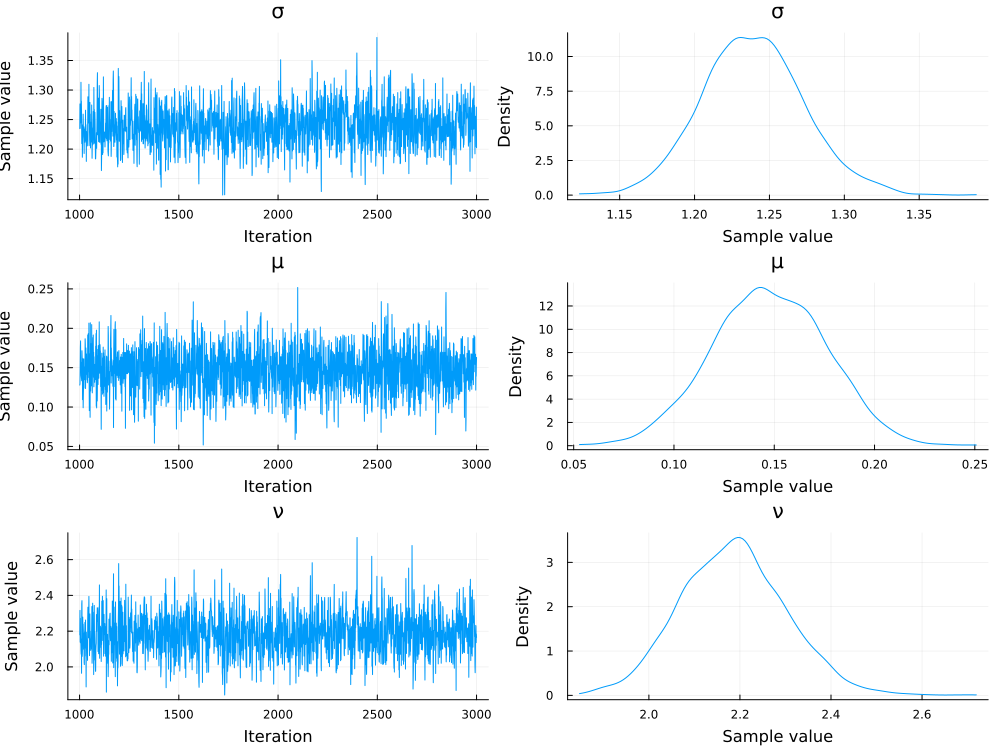

In [12]:
# To learn the Student's t-distribution:
chain_t = learn_distribution_mcmc(StudentTModel(), Rᵢ);

# You can now analyze chain_t and chain_laplace as before
plot(chain_t)


Next, for a direct comparison, we fit the **Laplace distribution** using the same MCMC methodology. This will produce a `chain` object containing posteriors for the Laplace parameters: mean (`μ`) and scale (`b`).

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


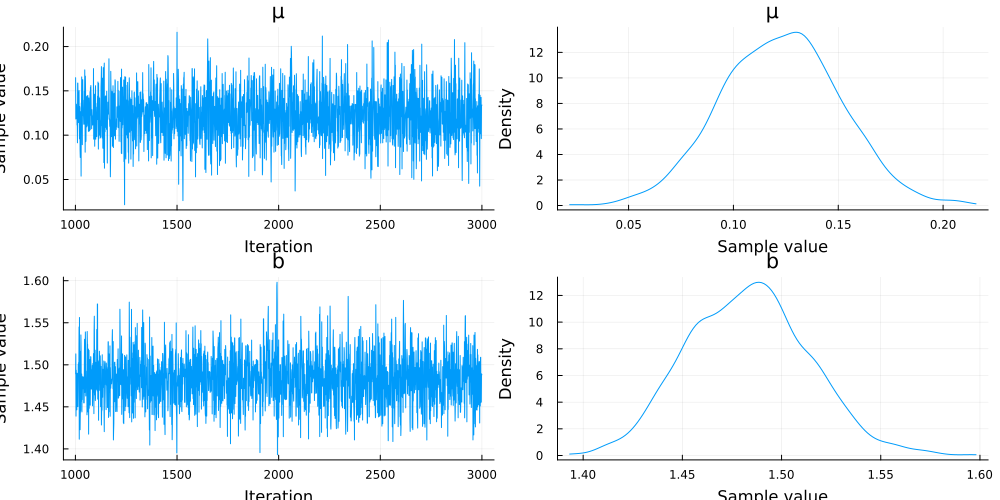

In [13]:
# To learn the Laplace distribution:
chain_laplace = learn_distribution_mcmc(LaplaceModel(), Rᵢ);

plot(chain_laplace)


Finally, we will prepare all of our fitted models for a head-to-head comparison. We will use the traditional **Maximum Likelihood Estimation (MLE)** to fit a Laplace distribution as a baseline. Then, we will bring together all the models—both MCMC and MLE—for a final comparison using visual plots and quantitative statistics.

In [14]:
# --- Prepare All Four Models ---

# 1. MLE Model
Laplace_MLE = fit_mle(Laplace, Rᵢ);

# 2. MCMC Models 
μ_t_mean = mean(chain_t[:μ])
σ_t_mean = mean(chain_t[:σ])
ν_t_mean = mean(chain_t[:ν])
StudentT_MCMC = LocationScale(μ_t_mean, σ_t_mean, TDist(ν_t_mean))

μ_laplace_mean = mean(chain_laplace[:μ])
b_laplace_mean = mean(chain_laplace[:b])
Laplace_MCMC = Laplace(μ_laplace_mean, b_laplace_mean);


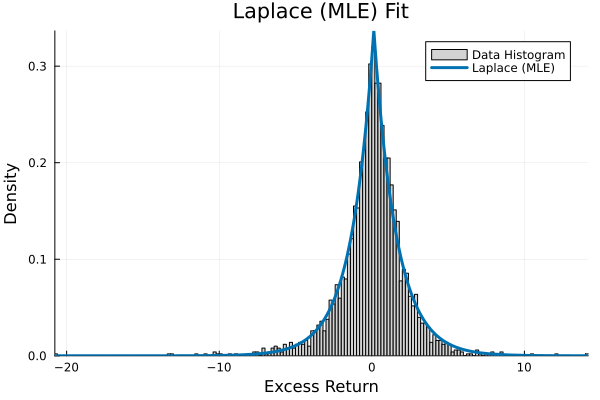

In [15]:
# --- Plot 1: Laplace (MLE) vs. Data ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the Laplace (MLE) distribution
plot!(x -> pdf(Laplace_MLE, x), lw=3, label="Laplace (MLE)", c="#0072B2") # Blue

title!("Laplace (MLE) Fit")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

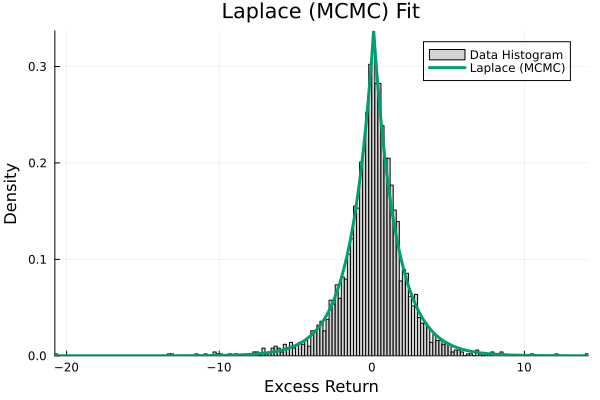

In [16]:
# --- Plot 3: Laplace (MCMC) vs. Data ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the Laplace (MCMC) distribution
plot!(x -> pdf(Laplace_MCMC, x), lw=3, label="Laplace (MCMC)", c="#009E73") # Bluish Green

title!("Laplace (MCMC) Fit")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

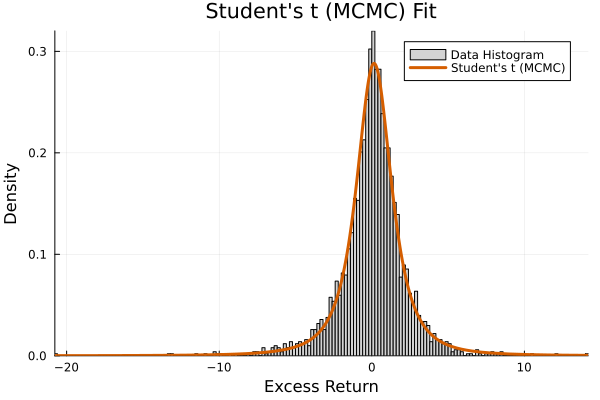

In [17]:
# --- Plot 2: Student's t (MCMC) vs. Data ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the Student's t (MCMC) distribution
plot!(x -> pdf(StudentT_MCMC, x), lw=3, label="Student's t (MCMC)", c="#D55E00") # Vermillion/Orange

title!("Student's t (MCMC) Fit")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

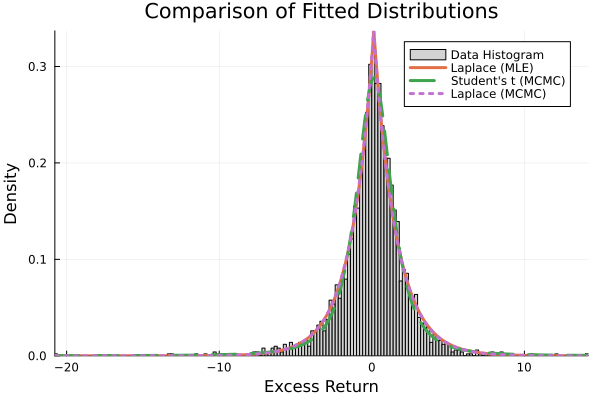

In [18]:
# ---  Visual Comparison of Four Distributions ---

# Create a histogram of the actual returns data
histogram(Rᵢ, normalize=:pdf, bins=200, label="Data Histogram", c=:lightgray)

# Plot the four models
plot!(x -> pdf(Laplace_MLE, x), lw=3, label="Laplace (MLE)")
plot!(x -> pdf(StudentT_MCMC, x), lw=3, label="Student's t (MCMC)", ls=:dash)
plot!(x -> pdf(Laplace_MCMC, x), lw=3, label="Laplace (MCMC)", ls=:dot)

title!("Comparison of Fitted Distributions")
xlabel!("Excess Return")
ylabel!("Density")
xlims!(extrema(Rᵢ))

In [19]:
# --- UPDATED: Quantitative Comparison of Four Distributions ---

# A. Summary Statistics
println("--- Summary Statistics ---")
println("Laplace (MLE):")
println("  Mean:      ", mean(Laplace_MLE))
println("  Variance:  ", var(Laplace_MLE))
println("  Kurtosis:  ", kurtosis(Laplace_MLE))

println("\nStudent's t (MCMC):")
println("  Mean:      ", mean(StudentT_MCMC))
println("  Variance:  ", var(StudentT_MCMC))
println("  Kurtosis:  ", kurtosis(StudentT_MCMC))

println("\nLaplace (MCMC):")
println("  Mean:      ", mean(Laplace_MCMC))
println("  Variance:  ", var(Laplace_MCMC))
println("  Kurtosis:  ", kurtosis(Laplace_MCMC))


# B. AIC Comparison (Lower is Better)
log_like_L_MLE = loglikelihood(Laplace_MLE, Rᵢ)
log_like_T_MCMC = loglikelihood(StudentT_MCMC, Rᵢ)
log_like_L_MCMC = loglikelihood(Laplace_MCMC, Rᵢ)

aic_L_MLE = 2*2 - 2*log_like_L_MLE
aic_T_MCMC = 2*3 - 2*log_like_T_MCMC
aic_L_MCMC = 2*2 - 2*log_like_L_MCMC

println("\n--- Model Comparison (Lower AIC is Better) ---")
println("AIC for Laplace (MLE):       ", aic_L_MLE)
println("AIC for Laplace (MCMC):      ", aic_L_MCMC)
println("AIC for Student's t (MCMC):  ", aic_T_MCMC)

--- Summary Statistics ---
Laplace (MLE):
  Mean:      0.13330821717648392
  Variance:  4.3965111938957895
  Kurtosis:  3.0

Student's t (MCMC):
  Mean:      0.14740474552650285
  Variance:  18.102568706190556
  Kurtosis:  Inf

Laplace (MCMC):
  Mean:      0.12258414190182364
  Variance:  4.399536330872342
  Kurtosis:  3.0

--- Model Comparison (Lower AIC is Better) ---
AIC for Laplace (MLE):       10497.331660166177
AIC for Laplace (MCMC):      10497.514120952499
AIC for Student's t (MCMC):  10514.282047685687


In [20]:
# Choose one of these to be your distribution in the variable d that will be used for generating CDF
d = Laplace_MLE;  # StudentT_MCMC or Laplace_MCMC or Laplace_MLE

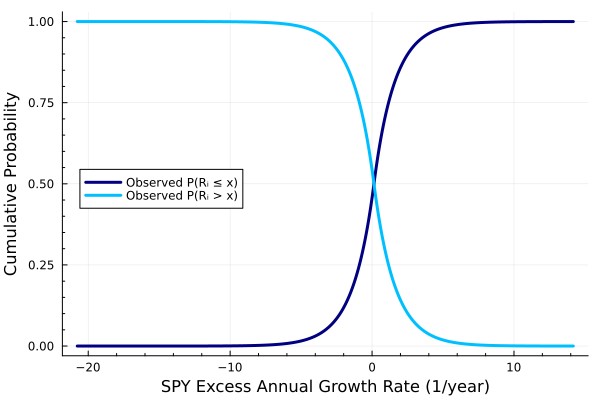

In [21]:
let

    # regions of return -
    number_of_samples = 1000;
    minimum_obs_growth = minimum(in_sample_dataset);
    maximum_obs_growth = maximum(in_sample_dataset);
    RA = range(minimum_obs_growth,stop = maximum_obs_growth, length = number_of_samples) |> collect;

    X = Array{Float64,2}(undef, number_of_samples,2);
    for i ∈ eachindex(RA)

        X[i,1] = RA[i];
        X[i,2] = cdf(d, RA[i]);
    end

    plot(X[:,1], X[:,2], lw=3, c=:navy, label="Observed P(Rᵢ ≤ x)", xminorticks=5, yminorticks=5)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="Observed P(Rᵢ > x)", legend=:left)

    xlabel!("$(ticker) Excess Annual Growth Rate (1/year)", fontsize=18);
    ylabel!("Cumulative Probability", fontsize=18);
end

Next, we generate the percentile cutoffs that we use to establish the bounds that correspond to each category of return, i.e., `super bad` or `super good`, etc.

In [22]:
percentage_cutoff = range(0.0,stop=1.0,length=(number_of_states+1)) |> collect

81-element Vector{Float64}:
 0.0
 0.0125
 0.025
 0.0375
 0.05
 0.0625
 0.075
 0.0875
 0.1
 0.1125
 0.125
 0.1375
 0.15
 ⋮
 0.8625
 0.875
 0.8875
 0.9
 0.9125
 0.925
 0.9375
 0.95
 0.9625
 0.975
 0.9875
 1.0

Now that we have the cutoffs, compute the lower and upper bound for each potentiual category. To do this, we'll use the [quantile function](https://juliastats.org/Distributions.jl/stable/univariate/#Statistics.quantile-Tuple{UnivariateDistribution,%20Real}) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). For a given `0 ≤ q ≤ 1`, `quantile(d, q)` is the smallest value `x`
for which `cdf(d, x) ≥ q`.

In [23]:
bounds = Array{Float64,2}(undef, number_of_states, 3)
for s ∈ states
    bounds[s,1] = quantile(d,percentage_cutoff[s])
    bounds[s,2] = quantile(d,percentage_cutoff[s+1])
    bounds[s,3] = s
end
bounds

80×3 Matrix{Float64}:
 -Inf       -5.33601   1.0
  -5.33601  -4.30832   2.0
  -4.30832  -3.70716   3.0
  -3.70716  -3.28062   4.0
  -3.28062  -2.94978   5.0
  -2.94978  -2.67946   6.0
  -2.67946  -2.45091   7.0
  -2.45091  -2.25293   8.0
  -2.25293  -2.0783    9.0
  -2.0783   -1.92208  10.0
  -1.92208  -1.78077  11.0
  -1.78077  -1.65176  12.0
  -1.65176  -1.53309  13.0
   ⋮                  
   1.91838   2.04739  69.0
   2.04739   2.1887   70.0
   2.1887    2.34491  71.0
   2.34491   2.51954  72.0
   2.51954   2.71752  73.0
   2.71752   2.94608  74.0
   2.94608   3.2164   75.0
   3.2164    3.54724  76.0
   3.54724   3.97377  77.0
   3.97377   4.57494  78.0
   4.57494   5.60263  79.0
   5.60263  Inf       80.0

Now that we have the category bounds, let's take the excess return data and determine which state an excess return observation corresponds to. For each sample in the `in_sample_dataset`:
* Classify the sample value into one of the possible categories. Let `state = 1` equal the worst return, and `state = number_of_states` equal the best return. Save these results in the `encoded_in_sample` array:

In [24]:
encoded_in_sample = Array{Int64,1}();
for i ∈ eachindex(in_sample_dataset)
    value = in_sample_dataset[i];

    class_index = 1;
    for s ∈ states
        if (bounds[s,1] ≤ value && value < bounds[s,2])
            class_index = s;
            break;
        end
    end
    push!(encoded_in_sample, class_index);
end
encoded_in_sample

2514-element Vector{Int64}:
 24
 56
 41
 37
 44
 15
 45
 69
 30
 28
 35
 47
 10
  ⋮
 72
 70
 16
 62
 59
 16
 31
 63
 52
 45
 49
 22

This cell can be used to check the most frequent hidden state.

In [25]:
counts = countmap(encoded_in_sample) |> argmax;

In the matrix $\mathbf{T}$ compute the `counts` for transition from state `i` to state `j`:

In [26]:
T = zeros(number_of_states, number_of_states)
number_insample = length(encoded_in_sample);
for i ∈ 2:number_insample
    start_index = encoded_in_sample[i-1];
    stop_index = encoded_in_sample[i];
    T[start_index,stop_index] += 1;
end
T

80×80 Matrix{Float64}:
 8.0  5.0  0.0  2.0  3.0  0.0  0.0  1.0  …  1.0  1.0  1.0  2.0  0.0  0.0  2.0
 3.0  3.0  0.0  1.0  1.0  1.0  0.0  0.0     0.0  1.0  0.0  1.0  1.0  0.0  2.0
 2.0  2.0  1.0  1.0  0.0  0.0  2.0  0.0     0.0  0.0  1.0  1.0  0.0  0.0  1.0
 2.0  0.0  1.0  0.0  1.0  1.0  2.0  2.0     1.0  1.0  1.0  0.0  0.0  1.0  1.0
 4.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0     1.0  0.0  2.0  0.0  0.0  0.0  1.0
 0.0  1.0  2.0  0.0  1.0  2.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  2.0  1.0  1.0  1.0  0.0  0.0  1.0     0.0  2.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  1.0  1.0  3.0  0.0
 1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0     0.0  0.0  2.0  1.0  1.0  0.0  0.0
 2.0  1.0  1.0  2.0  1.0  0.0  0.0  0.0  …  1.0  0.0  0.0  1.0  1.0  0.0  0.0
 3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0     2.0  1.0  1.0  1.0  1.0  0.0  0.0
 1.0  2.0  1.0  0.0  0.0  0.0  0.0  0.0  

From the `counts` matrix $\mathbf{T}$, compute the transtion probability matrix $\hat{\mathbf{T}}$:

In [27]:
T̂ = zeros(number_of_states, number_of_states)
for row ∈ states
    Z = sum(T[row,:]);
    for col ∈ states
        T̂[row,col] = (1/Z)*T[row,col]
    end
end
T̂

80×80 Matrix{Float64}:
 0.163265   0.102041   0.0        …  0.0        0.0        0.0408163
 0.09375    0.09375    0.0           0.03125    0.0        0.0625
 0.0666667  0.0666667  0.0333333     0.0        0.0        0.0333333
 0.0625     0.0        0.03125       0.0        0.03125    0.03125
 0.148148   0.037037   0.0           0.0        0.0        0.037037
 0.0        0.0322581  0.0645161  …  0.0        0.0        0.0
 0.0769231  0.0        0.0384615     0.0        0.0        0.0
 0.0285714  0.0571429  0.0285714     0.0        0.0        0.0
 0.0        0.03125    0.0           0.03125    0.09375    0.0
 0.0384615  0.0        0.0           0.0384615  0.0        0.0
 0.0740741  0.037037   0.037037   …  0.037037   0.0        0.0
 0.1        0.0666667  0.0           0.0333333  0.0        0.0
 0.04       0.08       0.04          0.0        0.04       0.0
 ⋮                                ⋱                        
 0.0526316  0.0526316  0.0           0.0        0.0        0.0
 0.0       

### Generate the stationary distribution from the estimated $\hat{\mathbf{T}}$ matrix
Generate the stationary distribution for the estimated transition matrix $\hat{\mathbf{T}}$ and use it to construct a [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) representing the stationary distrubution, save the [Categorical distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Categorical) in the `π̄`-variable:

In [28]:
power_value = 50;
π̄ = (T̂^power_value) |> tmp -> Categorical(tmp[1,:]); # compute the stationary distribution (approx value is ok)

## Task 2: Improving the Model with Jumps

Having established the primary weakness of the standard HMM, we now test if the modified model that includes price jumps can address this shortcoming. We will run the same autocorrelation analysis on the jump model's output to directly compare its ability to generate realistic volatility clustering.

In this task, we test if a modified Markov model that includes price jumps can address the shortcomings of the simple HMM. We will run the same autocorrelation analysis on the jump model's output to directly compare its ability to generate realistic volatility clustering.
Suppose every so often, instead of transitioning to the next state by sampling the transition matrix, we jump to a __tail state__ of the cumulative distribution. We then stay in one of the tail states for a random number of steps, governed by a [Possion distribution](https://en.wikipedia.org/wiki/Poisson_distribution).



To explore this idea, we built [a `MyHiddenMarkovModelWithJumps` instance](src/Types.jl), which holds the same data as the non-jump model. However, we now have two new parameters: the `ϵ::Float64` parameter controls the frequency with which we observe jumps, and the `λ::Int64` parameter is the mean number of events that occur in a given time frame.

We save this model in the `jump_model::MyHiddenMarkovModelWithJumps` variable

In [29]:
jump_model = let

    model = build(MyHiddenMarkovModelWithJumps, (
        states = states,
        T = T̂,
        E = E,
        ϵ = 0.00005, # fraction of steps that we have a jump event
        λ = 77, # mean number of jump events
    ));

    model;
end;

### Implement the `MARKOV-SIMULATION` to generate hypothetical return sequences

Generate 'number_of_paths' example sequences, each containing 'number_of_steps' days. These variables determine the length and number of our hypothetical return sequences. Assume each path starts from a draw from the stationary distribution `π̄.`
* Save the simulated return sequences in the `archive::Array{Int64,2}(undef, number_of_steps, number_of_paths)` array, where the `row` index corresponds to a path, and the `col` index corresponds to a day.
* We have implemented some shortcut logic to speed up the implementation. To evaluate the Markov model for a `number_of_steps,` issue the command `model(start_state, number_of_steps).` This will compute a chain with `number_of_steps` starting as `start_state` and return the simulated sequence as an `array.`

In [30]:
number_of_steps = maximum_number_trading_days;
encoded_archive_with_jumps = let
    encoded_archive = Array{Int64,2}(undef, number_of_steps, number_of_paths);
    for i ∈ 1:number_of_paths
        start_state = rand(π̄);

        @show i

        tmp = jump_model(start_state, number_of_steps)
        for j ∈ 1:number_of_steps
            encoded_archive[j,i] = tmp[j]
        end
    end
    encoded_archive
end;

i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
number_of_jumps = 67
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
number_of_jumps = 82
i = 21
number_of_jumps = 80
i = 22
i = 23
number_of_jumps = 110
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
number_of_jumps = 86
number_of_jumps = 73
i = 33
i = 34
i = 35
number_of_jumps = 84
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
number_of_jumps = 71
i = 46
i = 47
i = 48
i = 49
number_of_jumps = 63
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
number_of_jumps = 82
i = 65
i = 66
i = 67
number_of_jumps = 87
i = 68
i = 69
i = 70
i = 71
number_of_jumps = 103
i = 72
i = 73
i = 74
i = 75
number_of_jumps = 78
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
number_of_jumps = 79
i = 82
number_of_jumps = 81
i = 83
i = 84
i = 85
i = 86
number_of_jumps = 67
i = 87
i = 88
i = 89
i = 90
number_of_jumps = 82
i = 91
i = 92
i = 93

### Decode operation
To turn the state $s\in\mathcal{S}$ back into an excess return value, we need to __decode__ the state. To do this, let's construct a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) describing the observed return values associated with each state in the `encoded_in_sample` dataset.
* We collect the observed excess return samples associated with a particular state $s$, store them in a `tmp` array, and use [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to estimate a [Normal distribution exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal)

In [31]:
decode_distribution_model = Dict{Int,Normal}()
for s ∈ states

    # what indexes correspond to state s
    index_collection_state_s = findall(x-> x == s, encoded_in_sample);
    tmp = Array{Float64,1}();
    for i ∈ index_collection_state_s
        decoded_value = Rᵢ[i];
        push!(tmp, decoded_value);
    end
    decode_distribution_model[s] = fit_mle(Normal,tmp);
end
decode_distribution_model;

In [32]:
in_sample_decoded_archive_with_jumps = let
    in_sample_decoded_archive = Array{Float64,2}(undef, number_of_steps, number_of_paths);
    for i ∈ 1:number_of_paths
        for j ∈ 1:number_of_steps
            s = encoded_archive_with_jumps[j,i];
            in_sample_decoded_archive[j,i] =  decode_distribution_model[s] |> d -> rand(d)
        end
    end
    in_sample_decoded_archive # actual excess growth value
end;

In [33]:
in_sample_decoded_archive_with_jumps

2515×100 Matrix{Float64}:
  1.27334   -1.01036    -0.954336  …  -0.724405  -1.17666     -0.846149
 -0.471245  -0.363246   -1.41417       1.33752    0.0171311   -2.01134
  0.222427   0.306397   -3.11319      -0.348666   0.0823369    2.42257
 -0.352339  -0.13027     2.80586      -0.360344   0.00173592   1.18794
  0.593342  -0.941072    1.0675        0.24397    1.41938      4.33857
  0.673595  -1.36227     3.19493   …   0.954504   1.37837      1.0725
  0.287266  -0.487558    0.871931      0.550682   1.21339     -1.22668
  1.19304   -0.785457   -1.09739       0.324806  -0.0874879   -0.134919
  1.44762   -0.0756062   0.750511      0.931681  -0.22655     -0.614224
  0.780451   0.233633    0.151518     -1.15577    0.270844     1.52136
 -0.289874  -0.585055   -0.435901  …  -0.371133   0.322261    -1.34497
  0.149192   1.02866     3.27315      -5.0211     0.585793     1.56212
  0.224574  -0.445908    3.12366      -2.12551   -0.113268    -0.619729
  ⋮                                ⋱            

`Unhide` the code block below to see how we plotted the observed and simulated excess annual growth rate distribution for the in-sample data. These simulated returns are generated using the jump model.

### Visualize an example in-sample jump return trajectory
`Unhide` the code block to see how we plotted the observed (red) and simulated (blue) excess growth rate values for a randomly selected sample model generated sample path.

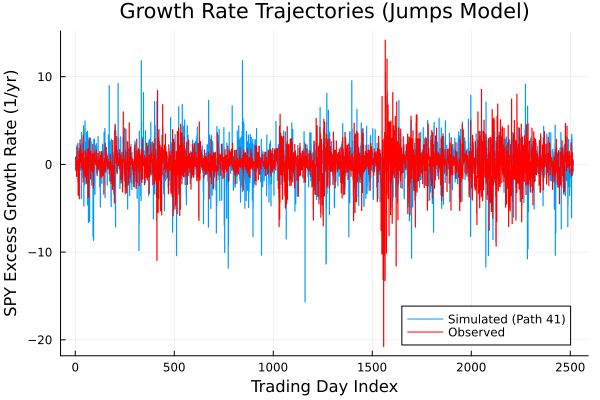

In [34]:
let
    # Select a random path to plot, just like in your working example
    index_to_plot = 41# rand(1:number_of_paths)

    # Plot the SIMULATED data first, creating the plot
    plot(in_sample_decoded_archive_with_jumps[:,index_to_plot], linetype=:steppost, label="Simulated (Path $(index_to_plot))")

    # Add the OBSERVED data to the plot, slicing it to match the simulation length
    plot!(in_sample_dataset[1:(number_of_steps - 1)], linetype=:steppost, c=:red, label="Observed")
    
    # Add labels and a title
    xlabel!("Trading Day Index")
    ylabel!("$(ticker) Excess Growth Rate (1/yr)")
    title!("Growth Rate Trajectories (Jumps Model)")
end

# savefig( joinpath(_PATH_TO_FIGURES, "Fig-$(ticker)-InSample-Return-Trajectories-WJ.pdf"))

### Check: Are the Simulated and observed in-sample distributions the same?
If our HMM is correct, then the observed excess growth rate distribution and the excess growth distribution calculated by our model should look like they are drawn from the same distribution.

In [35]:
let
    q = plot();
    density!(in_sample_decoded_archive_with_jumps[:,1], lw=2, c=:deepskyblue1, label="Simulated $(number_of_paths) Paths",
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    for i ∈ 2:number_of_paths
        density!(in_sample_decoded_archive_with_jumps[:,i], lw=1, c=:deepskyblue1, label="")
    end
    density!(in_sample_dataset, c=:red, lw=3, label="Observed")
    xlabel!("Excess Growth Rate $(ticker) (1/year)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
    current()

    # Save the figure
    savefig(joinpath(_PATH_TO_FIGURES, "Fig-$(ticker)-ExcessGrowthRate-Probability-Density-HMM-WJ.pdf"));

end

"/Users/abdulrahmanalswaidan/Desktop/Project-Repos/HMM-withJumps/figs/Fig-SPY-ExcessGrowthRate-Probability-Density-HMM-WJ.pdf"

#### Kolmogorov-Smirnov (K-S) Test

The Kolmogorov-Smirnov (K-S) test is a non-parametric method used to determine if two samples of data are drawn from the same underlying distribution. It works by quantifying the **maximum vertical distance** between the empirical cumulative distribution functions (ECDFs) of the two samples.

The hypotheses are:
- **H0 (null hypothesis):** The two samples are drawn from the same distribution.
- **H1 (alternative hypothesis):** The two samples are drawn from different distributions.

The K-S test is generally most sensitive to differences in the **center (i.e., around the median)** of the distributions.

To check this hypothesis, we will use [the `ApproximateTwoSampleKSTest` function from the `HypothesisTests.jl` package](https://github.com/JuliaStats/HypothesisTests.jl). Let's run it on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests the samples are from the same distribution):

In [36]:
ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive_with_jumps[:,rand(1:number_of_paths)])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0176276

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.8295

Details:
    number of observations:   [2514,2515]
    KS-statistic:              0.6250333784047517


However, we have `number_of_paths` example trajectories (not just one), so let's do the same test on each sample and compute an overall expected score. Specify a `pvalue_cutoff` value to check against. If the test returns `pvalue > pvalue_cutoff,` then we fail to reject `H0:null hypothesis`, i.e., `x` and `y` appear to be drawn from the same distribution.

In [37]:
let
    pvalue_cutoff = 0.05; # 95% cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = ApproximateTwoSampleKSTest(in_sample_dataset,in_sample_decoded_archive_with_jumps[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 100.0%


#### Anderson-Darling Test
The Anderson-Darling test is another method for testing whether two samples of data come from the same distribution. A key advantage of the A-D test over the K-S test is its higher sensitivity to differences in the tails of the distributions. This is particularly relevant for financial time series, where capturing tail risk and extreme events is critical.
Let's run it on a single (randomly selected) example trajectory to see what happens (most of the time, we fail to reject `H0`, i.e., the test suggests the samples are from the same distribution):

In [38]:
KSampleADTest(in_sample_dataset,in_sample_decoded_archive_with_jumps[:,rand(1:number_of_paths)])

k-sample Anderson-Darling test
------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.7843

Details:
    number of samples:        2
    number of observations:   5029
    SD of A²k:                0.7611095909929824
    A²k statistic:            0.46204864591500727
    standardized statistic:   -0.706798811171403
    modified test:            true
    p-value calculation:      asymptotic


However, we have `number_of_paths` example trajectories (not just one), so let's do the same test on each sample and compute an overall expected score. Specify a `pvalue_cutoff` value to check against. If the test returns `pvalue > pvalue_cutoff,` then we fail to reject `H0:null hypothesis`, i.e., `x` and `y` appear to be drawn from the same distribution.

In [39]:
let
    pvalue_cutoff = 0.05; # cutoff
    pass_counter = 0;
    for i ∈ 1:number_of_paths
        test_value = KSampleADTest(in_sample_dataset,in_sample_decoded_archive_with_jumps[:,i]) |> pvalue
        if (test_value > pvalue_cutoff)
            pass_counter += 1 # we pass (fail to reject) x and y are from the same distribution
        end
    end
    println("Pass percentage: $((pass_counter/number_of_paths)*100)%")
end

Pass percentage: 98.0%


### Stylized facts for in-sample dataset
This task compares the stylized facts for the observed insample and simulated excess growth datasets. In particular, we'll look at two stylized facts, namely, the autocorrelation of the excess growth rate and the volatility clustering, i.e., the autocorrelation of the absolute value of the excess growth rate.

#### Lack of Autocorrelation of Returns

First, we test a key stylized fact derived from the [random walk hypothesis](https://en.wikipedia.org/wiki/Random_walk_hypothesis): the autocorrelation of raw returns should be statistically insignificant for all lags. A model that successfully captures market behavior should be able to reproduce this lack of linear predictability.

##### Summary of Findings
* The plot below compares the autocorrelation of the observed **in-sample** returns (`Rᵢ`) with a randomly selected simulation path.
* As expected, both the real-world data (red) and the simulated data (blue) show near-zero autocorrelation that lies mostly within the 95% confidence interval.
* This confirms that our model successfully captures this feature of the data.

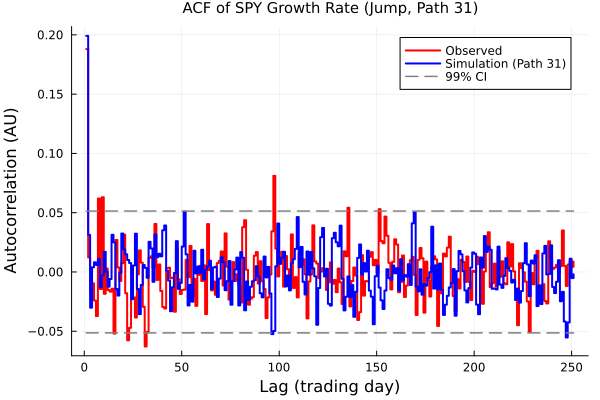

In [40]:
let
    random_index = rand(1:number_of_paths)
    simulated_path_jumps = in_sample_decoded_archive_with_jumps[:, random_index]
    plot_acf_comparison(Rᵢ, simulated_path_jumps, "ACF of $(ticker) Growth Rate (Jump, Path $(random_index))", random_index)
end
# savefig(joinpath(_PATH_TO_FIGURES, "Fig-$(ticker)-ACF-Growth-WJ.pdf"))

#### Volatility Clustering

Next, we examine a more complex stylized fact: **volatility clustering**. This is the tendency for large market movements (of either sign) to be followed by more large movements, and for calm periods to be followed by more calm periods. We test for this by analyzing the autocorrelation of the **absolute value** of the returns.

##### Summary of Findings
* The observed **in-sample** data (red line) shows positive and persistent autocorrelation in its absolute returns. This is the classic signature of volatility clustering.
* The plot below shows that the **Jump Markov model** (blue line) successfully replicates this pattern, demonstrating a significant improvement over a simple HMM. This confirms the jump component is crucial for capturing this key market dynamic.

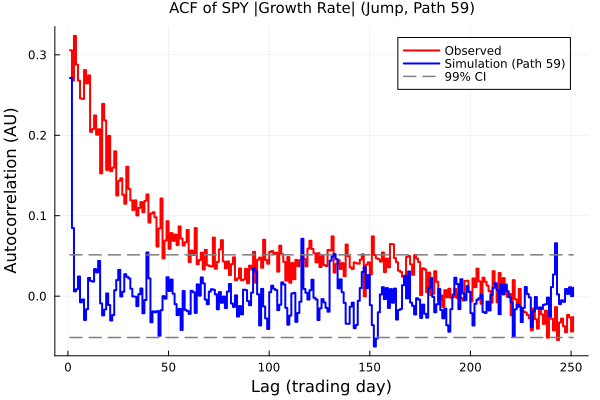

In [41]:
let
    random_index = rand(1:number_of_paths)
    simulated_path_jumps = in_sample_decoded_archive_with_jumps[:, random_index]
    plot_acf_comparison(Rᵢ, simulated_path_jumps, "ACF of $(ticker) |Growth Rate| (Jump, Path $(random_index))", random_index, is_absolute=true)
end
# savefig(joinpath(_PATH_TO_FIGURES, "Fig-$(ticker)-ACF-Absolute-Growth-WJ.pdf"))

## Task 3: Save the Model Artifacts
We'll use the hidden Markov Model (HMM) we developed here. Let's save the model to disk to save some time later on. Use the [save(...) method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl.git) to write a [model file in HDF5 binary format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format). First, we specify a `path` in the `path_to_save_file` variable:

In [42]:
# path_to_save_file = joinpath(_PATH_TO_DATA,"HMM-WJ-$(ticker)-daily-aggregate.jld2");

Then we write an [`HDF5 binary file`](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) holding our data to the location specified by `path_to_save_file.` We use the [save(...) function exported by the JLD2.jl package to write a binary save file](https://github.com/JuliaIO/JLD2.jl.git) (later we'll use to the `load(...)` function to reload this data):

In [43]:
# save(path_to_save_file, Dict("jump_model" => jump_model,
#         "decode"=>decode_distribution_model, "stationary"=>π̄,
#         "insampledataset"=>in_sample_dataset, "encoded_archive_with_jumps" => encoded_archive_with_jumps,
#         "in_sample_decoded_archive_with_jumps" => in_sample_decoded_archive_with_jumps,
#         ));

## Overall Conclusion

This analysis successfully demonstrated both the capabilities and the limitations of Hidden Markov Models for modeling financial returns.

The key findings are:
1.  **Data Characterization:** The underlying distribution of daily excess returns is characterized by "fat tails," which are better modeled by a **Student's t-distribution** than a Laplace or Normal distribution.

2.  **Standard HMM Performance:** A standard HMM is effective at capturing the basic return distribution and the lack of autocorrelation in raw returns. However, it **fundamentally fails** to reproduce the volatility clustering observed in the market.

3.  **Jump Model Superiority:** By introducing a mechanism for jumps, the modified HMM is able to successfully replicate volatility clustering. This confirms that **the HMM with jumps is a demonstrably superior model** for capturing the essential stylized facts of financial returns.

### Disclaimer: For Educational and Research Purposes Only

The content in this repository is provided strictly for informational, educational, and research purposes. It is not intended as, and should not be construed as, financial advice, an offer, or a solicitation to buy or sell any securities or derivative products.

#### Risk Warning

Trading and investing involve substantial risk. The models and strategies demonstrated here are for illustrative purposes only. Past performance, whether actual or backtested, is not a guarantee of future results.

You are solely responsible for any investment or trading decisions you make. Always conduct your own research and carefully assess your financial situation, investment objectives, and risk tolerance before trading or investing. You should only risk capital that you can afford to lose and that is not essential for your living expenses.